# 1. Setup

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot
import scipy
import scipy.stats
import statsmodels.api as sm
%matplotlib inline


# 2. Data Inspection

An admonition from last week was to always examine the dataset:
> Reminder: The first step in any type of data analysis is to look at your data.

In [2]:
# Looking at the first five lines of the file tells us that we have a header row
!head -n5 data/assign_wk2/flights.csv

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,2354,-11,21,0015,205,194,169,1448,0404,4,0430,0408,-22,0,0,,,,,,
2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,0002,-8,12,0014,280,279,263,2330,0737,4,0750,0741,-9,0,0,,,,,,
2015,1,1,4,US,840,N171US,SFO,CLT,0020,0018,-2,16,0034,286,293,266,2296,0800,11,0806,0811,5,0,0,,,,,,
2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,0015,-5,15,0030,285,281,258,2342,0748,8,0805,0756,-9,0,0,,,,,,


In [3]:
# Look at the last five lines... doesn't actually reveal anything new, but it's
# always best to be safe...
!tail -n5 data/assign_wk2/flights.csv

2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355,-4,22,0017,320,298,272,2611,0749,4,0819,0753,-26,0,0,,,,,,
2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355,-4,17,0012,227,215,195,1617,0427,3,0446,0430,-16,0,0,,,,,,
2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350,-9,17,0007,221,222,197,1598,0424,8,0440,0432,-8,0,0,,,,,,
2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353,-6,10,0003,161,157,144,1189,0327,3,0340,0330,-10,0,0,,,,,,
2015,12,31,4,B6,839,N534JB,JFK,BQN,2359,0014,15,14,0028,221,208,189,1576,0437,5,0440,0442,2,0,0,,,,,,


In [4]:
# Count the total number of lines in the file:
!wc -l data/assign_wk2/flights.csv

5819080 data/assign_wk2/flights.csv


# 3. Load and Verify Data

> Load flights.csv into a dataframe and handle the missing values.
> Justify your approach!
>
> Warning!!
> You are going to need some of the rows/columns with missing values, so don't just throw them away
> while creating your dataframe

In [5]:
# Upon initial attempt to load, received the following warning:
# DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import
# or set low_memory=False.
#
# According to the documentation for pandas.read_csv:
# low_memory : bool, default True
#     Internally process the file in chunks, resulting in lower memory use
#     while parsing, but possibly mixed type inference. To ensure no mixed
#     types either set False, or specify the type with the dtype parameter
#
# So, we can use low_memory=False ... this is also documented in the Clean
# Flights notebook
#
# (It turns out that Columns 7 and 8 are the airport identifiers, which are
# sometimes strings and sometimes integers ... this is also documented in the
# Clean Flights notebook)
#
# One more note: there's a header row in the data, but read_csv infers this info
# by default (can be controlled with the 'header' argument)
flights_df = pd.read_csv('data/assign_wk2/flights.csv', low_memory=False)

In [6]:
# Based on the line count above, we expect 5819079 rows
# (5819080 total rows, but one row is the header row)
flights_df.shape

(5819079, 31)

In [7]:
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Clean the Data

## 4.1 Remove Unused Columns

In [8]:
# NOTE: This mostly matches the columns removed by the Clean Flights notebook,
#       but I chose to keep AIR_TIME based on the assumption that the ability
#       to make up time is predicted better by AIR_TIME (i.e. SCHEDULED_TIME
#       probably includes taxiing and ground-crew actions, which don't offer
#       the same opportunity to make up time ... LOL, I'm completely guessing
#       here, but it sounds good!)
flights_df.drop([
    'AIRLINE_DELAY',
    'AIR_SYSTEM_DELAY',
    'CANCELLATION_REASON',
    'LATE_AIRCRAFT_DELAY',
    'SECURITY_DELAY',
    'TAIL_NUMBER',
    'TAXI_IN',
    'TAXI_OUT',
    'WEATHER_DELAY',
    'WHEELS_ON',
    'WHEELS_OFF'],
    axis='columns',
    inplace=True)

flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,2015,1,1,4,AS,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,169.0,1448,430,408.0,-22.0,0,0
1,2015,1,1,4,AA,2336,LAX,PBI,10,2.0,-8.0,280.0,279.0,263.0,2330,750,741.0,-9.0,0,0
2,2015,1,1,4,US,840,SFO,CLT,20,18.0,-2.0,286.0,293.0,266.0,2296,806,811.0,5.0,0,0
3,2015,1,1,4,AA,258,LAX,MIA,20,15.0,-5.0,285.0,281.0,258.0,2342,805,756.0,-9.0,0,0
4,2015,1,1,4,AS,135,SEA,ANC,25,24.0,-1.0,235.0,215.0,199.0,1448,320,259.0,-21.0,0,0


## 4.2 Remove Cancelled Flights

In [9]:
# Similar to the query performed by Clean Flights, but I wanted to try out
# a complex query (thanks Stack Overflow :) )
#
# ... also, let's collect some metrics
isnull = flights_df[flights_df.ARRIVAL_DELAY.isnull()]
cancelled = flights_df[flights_df.ARRIVAL_DELAY.isnull() & flights_df.CANCELLED == 1]

isnull_ratio = len(isnull) / len(flights_df)
cancelled_ratio = len(cancelled) / len(isnull)

print(f'Percentage of flights in data set that have invalid ARRIVAL_DELAY: {isnull_ratio: .1%}')
print(f'Percentage of invalid ARRIVAL_DELAY flights that were cancelled:   {cancelled_ratio:.1%}')

flights_df.drop(cancelled.index, inplace=True)

# Verify that the drop command did what was expected
assert len(flights_df[flights_df.CANCELLED != 0]) == 0

remaining_arrival_delay_null = len(flights_df[flights_df.ARRIVAL_DELAY.isnull()])
print(f'Number of remaining rows with invalid ARRIVAL_DELAY: {remaining_arrival_delay_null}')

Percentage of flights in data set that have invalid ARRIVAL_DELAY:  1.8%
Percentage of invalid ARRIVAL_DELAY flights that were cancelled:   85.5%
Number of remaining rows with invalid ARRIVAL_DELAY: 15187


## 4.3 What are **`SCHEDULED_ARRIVAL`** and **`ARRIVAL_TIME`** values?

I think that **`SCHEDULED_ARRIVAL`** and **`ARRIVAL_TIME`** values are not
fundamental integers, but representations of `[h]hmm`

For example, these values range between `1` and `2400`, which resembles military
time (which ranges between 0000 and 2359, left-padded by zeros)

Also, if we look at a random sample, we don't see any cases where the last
two digits exceed `59`

In [10]:
print(f'SCHEDULED_ARRIVAL range: {int(flights_df.SCHEDULED_ARRIVAL.min()):04d} - {int(flights_df.SCHEDULED_ARRIVAL.max()):04d}')
print(f'ARRIVAL_TIME      range: {int(flights_df.ARRIVAL_TIME.min()):04d} - {int(flights_df.ARRIVAL_TIME.max()):04d}')

flights_df.sample(20)[['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']]

SCHEDULED_ARRIVAL range: 0001 - 2400
ARRIVAL_TIME      range: 0001 - 2400


,SCHEDULED_ARRIVAL,ARRIVAL_TIME
5570775,820,748.0
1830725,1615,1614.0
5246267,2131,2122.0
5122678,2030,2026.0
1543848,1846,1833.0
2316256,1811,2146.0
3197609,1738,1739.0
4091081,1118,1119.0
1027186,758,755.0
48158,1038,1049.0


## 4.4 Impute ARRIVAL_DELAY

The column **`ARRIVAL_DELAY`** tells you the number of minutes the flight actually
arrived verses the scheduled arrival.  There are a fair number of missing values
for this column, impute (see demo below) this column. Document your approach!

* *Hint*: A negative number means the flight arrived early.
* *Hint*: What other columns might you use to fill in this missing data.

From Clean Flights notebook:

> Well, it's time to just start making some assumptions and documenting our process. Here is my approach to filling in the missing arrival_delay values.
>    1. if we can calculate the arrival_delay value based on scheduled_arrival and arrival_time
>    2. if a flight leaves early or on-time, it will arrive early the same number of minutes
>    3. if a flight leaves late, 15% or less than the flight duration, it will make that time up in the air and arrive on time
>    4. if a flight leaves late, more than 15% of the flight duration, it will be late the amount of time they left late - 15% of the flight duration.

**NOTE**: Recall that I'm interpreting *flight duration* to be **`AIR_TIME`** vice
          **`SCHEDULED_TIME`**

**NOTE**: Based on the analysis of **`SCHEDULED_ARRIVAL`** and **`ARRIVAL_TIME`**,
          they can't be treated as normal integers.  See **`FlightInfo._toDateTime`**

In [11]:

# This class is used as both a test/mock object and it houses useful utilities
class FlightInfo(object):

    @staticmethod
    def create(**kwargs):
        f = FlightInfo()

        for k, v in kwargs.items():
            setattr(f, k, v)

        return f

    @staticmethod
    def flightDuration(row):
        if not np.isnan(row.AIR_TIME):
            return row.AIR_TIME

        if np.isnan(row.SCHEDULED_TIME):
            print(
                f'WARNING: Neither AIR_TIME nor SCHEDULED_TIME are valid for {row.AIRLINE}/{row.FLIGHT_NUMBER} on {row.YEAR}-{row.MONTH}-{row.DAY}')

        return row.SCHEDULED_TIME

    @staticmethod
    def calculateArrivalDelayInMinutes(row):
        try:
            t1 = FlightInfo._toDateTime(row, row.SCHEDULED_ARRIVAL)
            t2 = FlightInfo._toDateTime(row, row.ARRIVAL_TIME)
            diff = t2 - t1
            return int(diff.total_seconds()) // 60
        except ValueError:
            return float('nan')

    @staticmethod
    def _toDateTime(row, field_value: int) -> datetime.datetime:
        # I think that SCHEDULED_ARRIVAL and ARRIVAL_TIME values are not fundamental
        # integers, but representations of [h]hmm.
        # See "4.3 What are SCHEDULED_ARRIVAL and ARRIVAL_TIME values?" section
        # below for evidence.
        #
        # Based on the idea that these values aren't normal integers, I use
        # some Python datetime utilities to convert the fields to datetime
        # objects, which can be reliably compared.

        # Special case: if the input is 2400, set to 2359
        # (Python and other time systems expect max of 2359)
        value = field_value if field_value < 2400 else 2359
        time_str = f'{int(value):04d}'
        time_str = f'{time_str[:2]}:{time_str[2:]}'

        scheduled_departure_str = f'{row.YEAR:04d}-{row.MONTH:02d}-{row.DAY:02d} {time_str}'
        dt = datetime.datetime.fromisoformat(scheduled_departure_str)

        # Special case: if the input is 2400, restore the removed minute
        if field_value > 2359:
            dt = dt + datetime.timedelta(seconds=60)

        return dt


fi = FlightInfo.create(TEST_ATTRIBUTE=1)
assert fi.TEST_ATTRIBUTE == 1

assert FlightInfo._toDateTime(FlightInfo.create(YEAR=2021, MONTH=10, DAY=29), 123).isoformat() == '2021-10-29T01:23:00'
assert FlightInfo._toDateTime(FlightInfo.create(YEAR=2021, MONTH=10, DAY=29),
                              1234).isoformat() == '2021-10-29T12:34:00'
assert FlightInfo.calculateArrivalDelayInMinutes(FlightInfo.create(YEAR=2021,
                                                                   MONTH=10,
                                                                   DAY=29,
                                                                   SCHEDULED_ARRIVAL=1234,
                                                                   ARRIVAL_TIME=1236)) == 2

# Special test  for 2400 hours
assert FlightInfo.calculateArrivalDelayInMinutes(FlightInfo.create(YEAR=2021,
                                                                   MONTH=10,
                                                                   DAY=29,
                                                                   SCHEDULED_ARRIVAL=2300,
                                                                   ARRIVAL_TIME=2400)) == 60


def fill_missing_delay(row):
    if ~np.isnan(row.ARRIVAL_DELAY):
        return row.ARRIVAL_DELAY

    if ~np.isnan(row.SCHEDULED_ARRIVAL) and ~np.isnan(row.ARRIVAL_TIME):
        return FlightInfo.calculateArrivalDelayInMinutes(row)

    if row.DEPARTURE_DELAY <= 0:
        # NOTE: Removed call to np.negative ... by definition, the flight
        #       departed early if the DEPARTURE_DELAY is negative (as tested by
        #       the condition above) ... thus, returning DEPARTURE_DELAY
        #       (without double negation) yields a negative ARRIVAL_DELAY
        #       (i.e. an early arrival)
        return row.DEPARTURE_DELAY

    max_recovery_time = 0.15 * FlightInfo.flightDuration(row)

    if row.DEPARTURE_DELAY <= max_recovery_time:
        return float(0)

    # NOTE: Since I favored AIR_TIME (which is a shorter duration) over
    #       SCHEDULED_TIME, my data set tends to have a lower max_recovery_time
    #       and thus a slightly higher quantity of delayed flights
    #
    # NOTE: Removed call to np.negative ... as Test Case #4 below shows,
    #       when DEPARTURE_DELAY > (0.15 * AIR_TIME), the the difference
    #       between those two values will already be *positive*, indicating
    #       a late arrival
    return row.DEPARTURE_DELAY - max_recovery_time

# Let's test `fill_missing_delay` ...

# Test Case #0: When ARRIVAL_DELAY is a number, that number s/b returned
assert fill_missing_delay(FlightInfo.create(ARRIVAL_DELAY = 2)) == 2

# Test Case #1: If we can, calculate ARRIVAL_DELAY based on SCHEDULED_ARRIVAL
#               and ARRIVAL_TIME
assert fill_missing_delay(FlightInfo.create(ARRIVAL_DELAY = float('nan'),
                                            YEAR = 2015,
                                            MONTH = 1,
                                            DAY = 1,
                                            ARRIVAL_TIME=1233,
                                            SCHEDULED_ARRIVAL=1230)) == 3

# Test Case #2: If a flight leaves early or on-time, it will arrive early by
#               the same number of minutes
assert fill_missing_delay(FlightInfo.create(DEPARTURE_DELAY = -5,
                                            ARRIVAL_DELAY = float('nan'),
                                            SCHEDULED_ARRIVAL = float('nan'))) == -5

# Test Case #3: If a DEPARTURE_DELAY is 15% or less than the flight duration,
#               it will make that time up in the air and arrive on time
assert fill_missing_delay(FlightInfo.create(AIR_TIME=100,
                                            DEPARTURE_DELAY=14,
                                            ARRIVAL_DELAY=float('nan'),
                                            SCHEDULED_ARRIVAL=float('nan'))) == 0.0

# Test Case #4: If a DEPARTURE_DELAY is more than 15% of the flight duration,
#               it will be late the DEPARTURE_DELAY - 15% of the flight duration
assert fill_missing_delay(FlightInfo.create(AIR_TIME=100,
                                            DEPARTURE_DELAY=20,
                                            ARRIVAL_DELAY=float('nan'),
                                            SCHEDULED_ARRIVAL=float('nan'))) == 5.0


In [12]:
flights_df.ARRIVAL_DELAY = flights_df.apply(lambda row: fill_missing_delay(row), axis = 'columns')


In [13]:
flights_df[flights_df.ARRIVAL_DELAY.isnull()].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
1720237,2015,4,20,1,NK,174,FLL,LGA,1602,1857.0,175.0,NaN,NaN,NaN,1076,1900,NaN,NaN,1,0


In [14]:
# Select the exact flight number to control time of day (e.g. this flight always
# departs at ~1600) and then focus on flights that are delayed approximately
# the same amount
avg_nk174_arrival_delay = flights_df[(flights_df.AIRLINE == 'NK') &
                                     (flights_df.FLIGHT_NUMBER == 174) &
                                     (flights_df.DEPARTURE_DELAY >= 160) &
                                     (flights_df.DEPARTURE_DELAY <= 190)].ARRIVAL_DELAY.mean()

flights_df.ARRIVAL_DELAY.fillna(avg_nk174_arrival_delay, inplace=True)

flights_df[(flights_df.AIRLINE == 'NK') &
           (flights_df.FLIGHT_NUMBER == 174) &
           (flights_df.DEPARTURE_DELAY >= 160) &
           (flights_df.DEPARTURE_DELAY <= 190)]


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
540810,2015,2,5,4,NK,174,FLL,LGA,1610,1914.0,184.0,170.0,163.0,139.0,1076,1900,2157.0,177.0,0,0
895416,2015,2,28,6,NK,174,FLL,LGA,1604,1914.0,190.0,176.0,163.0,140.0,1076,1900,2157.0,177.0,0,0
1720237,2015,4,20,1,NK,174,FLL,LGA,1602,1857.0,175.0,NaN,NaN,NaN,1076,1900,NaN,179.8,1,0
3013860,2015,7,8,3,NK,174,FLL,LGA,1602,1907.0,185.0,178.0,204.0,171.0,1076,1900,2231.0,211.0,0,0
4331442,2015,9,27,7,NK,174,FLL,LGA,1609,1905.0,176.0,171.0,173.0,137.0,1076,1900,2158.0,178.0,0,0
5228822,2015,11,23,1,NK,174,FLL,LGA,1605,1905.0,180.0,175.0,151.0,136.0,1076,1900,2136.0,156.0,0,0


## 4.5 Remove Small/Regional Airports

In [15]:
flights_df['ORIGIN_AIRPORT_NAME_LEN'] = flights_df.ORIGIN_AIRPORT.apply(lambda x: len(x))
flights_df.drop(flights_df[flights_df['ORIGIN_AIRPORT_NAME_LEN'] > 3].index, inplace=True)

flights_df['DESTINATION_AIRPORT_NAME_LEN'] = flights_df.DESTINATION_AIRPORT.apply(lambda x: len(x))
flights_df.drop(flights_df[flights_df['DESTINATION_AIRPORT_NAME_LEN'] > 3].index, inplace=True)

In [16]:
flights_df.DESTINATION_AIRPORT.unique()

array(['SEA', 'PBI', 'CLT', 'MIA', 'ANC', 'MSP', 'DFW', 'ATL', 'IAH',
       'PDX', 'MCI', 'FLL', 'ORD', 'HNL', 'PHX', 'EWR', 'JFK', 'MCO',
       'BOS', 'BDL', 'ITO', 'SFO', 'KOA', 'OGG', 'MYR', 'DTW', 'LIH',
       'DEN', 'SJU', 'LAX', 'BWI', 'IAD', 'BQN', 'BUF', 'LGA', 'HOU',
       'SLC', 'PHL', 'SJC', 'OAK', 'LGB', 'TPA', 'DCA', 'TTN', 'LAS',
       'RSW', 'BRD', 'STL', 'RKS', 'MBS', 'SNA', 'MEI', 'MDW', 'SAN',
       'RIC', 'OTZ', 'PIT', 'JAX', 'MSY', 'ONT', 'PSP', 'BUR', 'DAL',
       'CVG', 'SMF', 'RDU', 'BNA', 'AUS', 'DSM', 'BOI', 'ELP', 'TUS',
       'SCC', 'HPN', 'STT', 'MDT', 'RHI', 'SBP', 'MKE', 'JNU', 'CMH',
       'CLD', 'KTN', 'CAK', 'CLE', 'GPT', 'IND', 'SAT', 'SRQ', 'BTV',
       'CHS', 'DAY', 'TUL', 'SAV', 'COS', 'GJT', 'BZN', 'PUB', 'HRL',
       'HDN', 'MEM', 'GEG', 'ORH', 'SYR', 'ACY', 'LBB', 'JAC', 'BIL',
       'EUG', 'ASE', 'TVC', 'MTJ', 'OKC', 'PVD', 'HSV', 'CDC', 'GSO',
       'YUM', 'ABQ', 'TLH', 'EGE', 'BTR', 'MOB', 'FWA', 'BIS', 'MFR',
       'APN', 'BHM',

In [17]:
flights_df.drop(['ORIGIN_AIRPORT_NAME_LEN', 'DESTINATION_AIRPORT_NAME_LEN'], axis='columns', inplace=True)

# 5. Analysis

> Provide an analysis of delayed flights based on the airport the flight originated from.
> Your analysis should answer the following questions.
> - Is the distribution of delayed flights normally distributed?
>     - Describe the shape of the distribution based on the QQ-plot.
> - What is the probability a flight leaving from a given airport will arrive at its destination late?
> Hint: Calculate the probability of late arrival at destination for each originating airport.
> - Determine the originating airport with the largest proportion of flights arriving late to their destination.  Do the same for the airport with the smallest proportion.
>      - What is the difference between probability and proportion? (see note below)
> - What is the mean and std of late arrival times for both of these airports.
>      - Based on the mean and std information ONLY, which airport seems like a better choice?
> - Use these two airports and compare their histograms of arrival delays with each other.
>      - Which airport seems like you would have a better chance at arriving at your destination on time? Use the histograms to backup your conclusion!

## 5.1 Is the distribution of delayed flights normally distributed?
* Describe the shape of the distribution based on the QQ-plot.

I begin the analysis by grouping the dataset by **`ORIGIN_AIRPORT`** ...

**`origin_airport_df`** will be a new DataFrame containing summary statistics
by **`ORIGIN_AIRPORT`**
* **`NUM_DELAYED`** contains the total number of delayed flights per origin
* **`NUM_FLIGHTS`** contains the total number of flights per origin
* **`NUM_ON_TIME`** contains the total number of on-time flights per origin
* **`LOCAL_DELAY_RATIO`** calculates the proportion of delayed flights based
  on the number of flights originating from the subject airport
* **`GLOBAL_DELAY_RATIO`** calculates the proportion of delayed flights based
  on the total number of flights across the system (all airports included)


In [18]:
def count_if_delayed(value):
    count = 0
    for v in value:
        if v > 0:
            count += 1
    return count

origin_airport_df = flights_df.groupby('ORIGIN_AIRPORT').agg(
    NUM_DELAYED=('ARRIVAL_DELAY', lambda x: count_if_delayed(x)),
    NUM_FLIGHTS=('ARRIVAL_DELAY', 'count'))

origin_airport_df['NUM_ON_TIME'] = origin_airport_df.NUM_FLIGHTS.subtract(origin_airport_df.NUM_DELAYED)
origin_airport_df['LOCAL_DELAY_RATIO'] = origin_airport_df.NUM_DELAYED.divide(origin_airport_df.NUM_FLIGHTS)
origin_airport_df['GLOBAL_DELAY_RATIO'] = origin_airport_df.NUM_DELAYED.divide(len(flights_df))

origin_airport_df.head()

,NUM_DELAYED,NUM_FLIGHTS,NUM_ON_TIME,LOCAL_DELAY_RATIO,GLOBAL_DELAY_RATIO
ORIGIN_AIRPORT,,,,,
ABE,834,2235,1401,0.373154,0.000159
ABI,687,2232,1545,0.307796,0.000131
ABQ,7015,18980,11965,0.369600,0.001337
ABR,246,663,417,0.371041,0.000047
ABY,310,867,557,0.357555,0.000059


### 5.1.A Global Analysis

This first analysis examines the proportion of delays across the system
globally (each origin airport considered against all other airports).

I believe, in this case, the statistics of the busiest airports skew the results
such that the vast majority of airports have an exceptionally low proportion
of delayed flights.

The boxplot (below left) illustrates the numerous airport outliers above the
maximum with orders of magnitude more flights than the 75 percentile of
airports.

The histogram (below center) shows the effect of using the total number of
flighs throughout the system - exceptionally low proportions for the vast
majority of origin airports.

The probability plot (below right, similar to a QQ-plot, but the left axis is
probabilities vice quantiles) illustrates the excessively low proportions
of delayed flights exhibited by the majority of airports when compared globally
(the graph does not begin its upward trajectory until well into the 1st
quantile).

Number of flights from the busiest origin airport:    344279
Number of flights from the least busy origin airport:     30


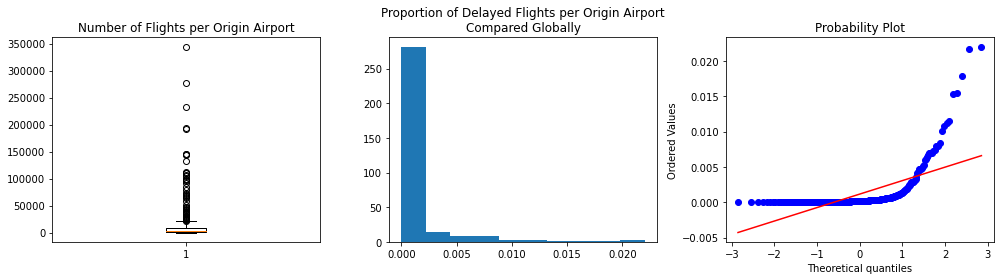

In [19]:
print(f'Number of flights from the busiest origin airport:    {origin_airport_df.NUM_FLIGHTS.max():>6}')
print(f'Number of flights from the least busy origin airport: {origin_airport_df.NUM_FLIGHTS.min():>6}')

matplotlib.pyplot.figure(figsize=(14.0, 4.0))
matplotlib.pyplot.subplot(1, 3, 1, title='Number of Flights per Origin Airport')
matplotlib.pyplot.boxplot(origin_airport_df.NUM_FLIGHTS)

matplotlib.pyplot.subplot(1, 3, 2, title='Proportion of Delayed Flights per Origin Airport\nCompared Globally')
matplotlib.pyplot.hist(origin_airport_df.GLOBAL_DELAY_RATIO)

ax = matplotlib.pyplot.subplot(1, 3, 3)
scipy.stats.probplot(origin_airport_df.GLOBAL_DELAY_RATIO, plot=ax)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 5.1.B Local Analysis

This analysis examines the proportion of delayed vs the number of flights at a
particular origin airport.

The histogram (below left) shows that the proportion of delayed flights is
more normally distributed when each origin airport is considered in isolation.
That is to say: a quick visual analysis of the histogram shows approximately
half of the airports have fewer than the mean number of delays and half of the
origin airports have more than the mean number of delays.

The corresponding probability plot (below center) yields a straight line 

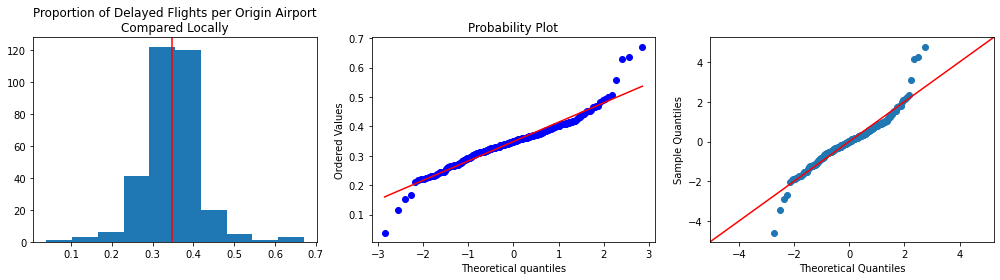

In [20]:
matplotlib.pyplot.figure(figsize=(14.0, 4.0))

matplotlib.pyplot.subplot(1, 3, 1, title='Proportion of Delayed Flights per Origin Airport\nCompared Locally')
matplotlib.pyplot.axvline(origin_airport_df.LOCAL_DELAY_RATIO.mean(), color='red')
matplotlib.pyplot.hist(origin_airport_df.LOCAL_DELAY_RATIO)

ax = matplotlib.pyplot.subplot(1, 3, 2)
scipy.stats.probplot(origin_airport_df.LOCAL_DELAY_RATIO, plot=ax)

ax = matplotlib.pyplot.subplot(1, 3, 3)
qq = sm.qqplot(origin_airport_df.LOCAL_DELAY_RATIO, fit=True, line='45', ax=ax)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()


## 5.2 What is the probability a flight leaving from a given airport will arrive at its destination late?

* **Hint**: Calculate the probability of late arrival at a destination for each
            originating airport.

*As I mentioned in the forums, my mindset for this analysis is that each*
*origin airport is considered in isolation... Here, I continue with that thread,*
*which means I'm probably way off from what you wanted...*

Since each airport's probability of a late flight itself has uncertainty, 
we need to account for the historical proportions in the calculation
(i.e. if the airport has very little historical proportion data,
we can't reliably predict if a flight will be late because the probability
itself is immature).

So... the numbers used in the calculation will be incremented from the
historical values using Laplace's Rule of Succession: if an airport has a
history of **`d`** delayed flights out of **`n`** total flights, we will
calculate the probability of **`d + 1`** delayed flights out of **`n + 2`**
total flights.  For origin airports with sparse data, this will help take into
account the lack of confidence.  For origin airports with sufficient data, this
calculation will not have an inordinate effect.

In [21]:
origin_airport_df['LAPLACE_LATE_PROB'] = origin_airport_df.apply(
    lambda row : (row.NUM_DELAYED + 1) / (row.NUM_FLIGHTS + 2),
    axis='columns')
    
origin_airport_df.sort_values('LAPLACE_LATE_PROB', ascending=False).head(3)


,NUM_DELAYED,NUM_FLIGHTS,NUM_ON_TIME,LOCAL_DELAY_RATIO,GLOBAL_DELAY_RATIO,LAPLACE_LATE_PROB
ORIGIN_AIRPORT,,,,,,
GST,51,76,25,0.671053,0.000010,0.666667
PPG,68,107,39,0.635514,0.000013,0.633028
ADK,56,89,33,0.629213,0.000011,0.626374


In [22]:
origin_airport_df.sort_values('LAPLACE_LATE_PROB', ascending=True).head(3)


,NUM_DELAYED,NUM_FLIGHTS,NUM_ON_TIME,LOCAL_DELAY_RATIO,GLOBAL_DELAY_RATIO,LAPLACE_LATE_PROB
ORIGIN_AIRPORT,,,,,,
CNY,8,205,197,0.039024,0.000002,0.043478
VEL,23,200,177,0.115000,0.000004,0.118812
BTM,100,648,548,0.154321,0.000019,0.155385


## 5.3 Determine the originating airport with the largest proportion of flights arriving late to their destination. Do the same for the airport with the smallest proportion.

### 5.3.1 What is the difference between probablility and proportion? (see note below)

***Probability*** describes the chances that a particular event might happen
whereas ***proportion*** describes how frequently an event actually happened.

A proportion (i.e. the ratio of successes to the number of executed trials) may
not match the hypothetical probability of an event due to factors such as
chance, bias, or unaccounted-for dependencies.

In [23]:
largest_late_proportion = origin_airport_df[origin_airport_df.LOCAL_DELAY_RATIO == 
                                            origin_airport_df.LOCAL_DELAY_RATIO.max()]
largest_late_proportion

,NUM_DELAYED,NUM_FLIGHTS,NUM_ON_TIME,LOCAL_DELAY_RATIO,GLOBAL_DELAY_RATIO,LAPLACE_LATE_PROB
ORIGIN_AIRPORT,,,,,,
GST,51,76,25,0.671053,0.00001,0.666667


In [24]:
smallest_late_proportion = origin_airport_df[origin_airport_df.LOCAL_DELAY_RATIO ==
                                             origin_airport_df.LOCAL_DELAY_RATIO.min()]
smallest_late_proportion


,NUM_DELAYED,NUM_FLIGHTS,NUM_ON_TIME,LOCAL_DELAY_RATIO,GLOBAL_DELAY_RATIO,LAPLACE_LATE_PROB
ORIGIN_AIRPORT,,,,,,
CNY,8,205,197,0.039024,0.000002,0.043478


## 5.4 What is the **`mean`** and **`std`** of late arrival times for both of these airports.
* Based on the **`mean`** and **`std`** information ONLY, which airport seems like a better choice?

The numbers below seem to make sense as **GST** refers to *Gustavas Airport* in
Alaska.  I can imagine that inclement weather causes many issues and the airport
seems too small to clear backlogged flights via other airlines.

**CNY** refers to *Canyonlands Regional Airport* in Utah and probably does not
deal with inclement weather as often as other areas.  The negative mean of
**`ARRIVAL_DELAY`** indicates that most flights leave *early*.  Presumably, this
is possible if all of the passengers are also available early and there are no
dependencies on other inbound flights.

**NOTE:** Last week, when looking at movie rankings, I eliminated certain films
          if they had too few reviews.  Similarly, one could argue that it would
          be more interesting to compare metrics among different categories such
          as *among the top 30 largest airports*, or
          *by region (Northeast, Southeast, Mid-West, West, West Coast, etc)*,
          etc.


In [25]:
worst_airport_df = flights_df[flights_df.ORIGIN_AIRPORT == largest_late_proportion.index.values[0]]
print(f'{worst_airport_df.ORIGIN_AIRPORT.values[0]} ARRIVAL_DELAY ... mean: {worst_airport_df.ARRIVAL_DELAY.mean(): 4.2f}, std: {worst_airport_df.ARRIVAL_DELAY.std(): 4.2f}')

best_airport_df = flights_df[flights_df.ORIGIN_AIRPORT == smallest_late_proportion.index.values[0]]
print(f'{best_airport_df.ORIGIN_AIRPORT.values[0]} ARRIVAL_DELAY ... mean: {best_airport_df.ARRIVAL_DELAY.mean(): 4.2f}, std: {best_airport_df.ARRIVAL_DELAY.std(): 4.2f}')

GST ARRIVAL_DELAY ... mean:  21.76, std:  38.22
CNY ARRIVAL_DELAY ... mean: -20.68, std:  12.55


## 5.5 Use these two airports and compare their histograms of arrival delays with each other.
* Which airport seems like you would have a better chance at arriving at your destination on time?
* Use the histograms to backup your conclusion!

The **GST** histogram indicates not only a high average delay (discussed
previously), but also exhibits a right skew indicating that there are numerous
outliers on the *"even later"* side of the histogram.  This is definitely an
airport to avoid.

The **CNY** histogram also exhibits a right skew which indicates outliers that
have longer delays.  However, in this case it is also easy to see that
there are very few cases which actually depart later than 10 minutes (visually
estimated).

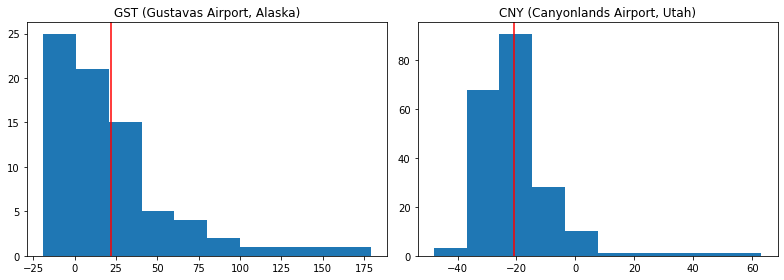

In [26]:
matplotlib.pyplot.figure(figsize=(11.0, 4.0))

matplotlib.pyplot.subplot(1, 2, 1, title='GST (Gustavas Airport, Alaska)')
matplotlib.pyplot.axvline(worst_airport_df.ARRIVAL_DELAY.mean(), color='red')
matplotlib.pyplot.hist(worst_airport_df.ARRIVAL_DELAY)

matplotlib.pyplot.subplot(1, 2, 2, title='CNY (Canyonlands Airport, Utah)')
matplotlib.pyplot.axvline(best_airport_df.ARRIVAL_DELAY.mean(), color='red')
matplotlib.pyplot.hist(best_airport_df.ARRIVAL_DELAY)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()


# Appendix A. Binomial Probability

Because of the way I analyzed this week's data, rightly or wrongly I did not
use Binomial probability.

This section dives a little deeper into binomial probability by focusing
specifically on DEN and examining the probability surrounding specific numbers
of flights being delayed.  Each trial has only two possible outcomes: *delayed*
or *not delayed*.  A success is defined as *delayed*.

## A.1 Setup

In [27]:
den = origin_airport_df[origin_airport_df.index == 'DEN']

den_daily_flights = int(den.NUM_FLIGHTS.values[0]/365)
den_daily_delayed_flights = int(den.NUM_DELAYED.values[0]/365)
den_delay_p = den.LOCAL_DELAY_RATIO.values[0]

print(f'DEN averages {den_daily_flights} flights per day, of which {den_daily_delayed_flights} are delayed ({den_delay_p:.2%})')

DEN averages 531 flights per day, of which 222 are delayed (41.84%)


## A.2 Binomial Probability Mass Function

Above, I showed that on average 222 flights are delayed at DEN each day (at
least, according to 2015 data).

Here, I graph values of the binomial probability mass formula roughly centered
around the value of 222.  The PMF function yields the probability of exactly *x*
successes in *n* trials.  So, we expect the PMF graph of DEN delayed flights to
peak around 222.

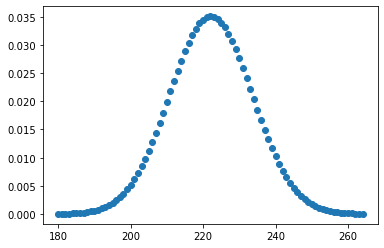

In [28]:
flights = range(180, int(den_daily_flights / 2))
pmf = [scipy.stats.binom.pmf(f, n=den_daily_flights, p=den_delay_p) for f in flights]

matplotlib.pyplot.scatter(flights, pmf)
matplotlib.pyplot.show()

## A.2 Binomial Cumulative Distribution Function

Here, I graph values of the binomial cumulative distribution formula, again
roughly centered around the value of 222.  The CDF function yields the
probability of *up to, but no more than x* successes in *n* trials.  So, we
expect the CDF graph of DEN delayed flights to begin rising before 222 and
reach its near-maximum afterwards.

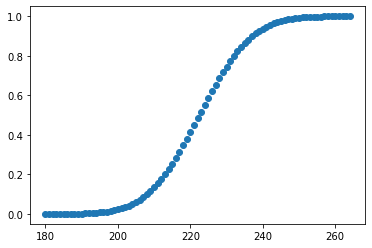

In [29]:
cdf = [scipy.stats.binom.cdf(f, n=531, p=0.42) for f in flights]
matplotlib.pyplot.scatter(flights, cdf)
matplotlib.pyplot.show()